## Introduction To PyTorch

In [0]:
import torch
import numpy as np

## What is PyTorch?

*   Framework for building deep learning models
*   Based on Python
*   Key features include autodifferentiation, tensor computation, and modules


In [0]:
a = np.array(([1,0],
              [0,1]))
print(a)
print(a.shape)

[[1 0]
 [0 1]]
(2, 2)


## Tensors


*   Just like numpy nd-arrays, except can be used for GPU computation
  *   Often necessary for neural network training due to the large computational costs



In [0]:
a_tensor = torch.from_numpy(a) #array to tensor
print(a_tensor)
print(a_tensor.shape)
a_tensor_2 = torch.tensor([[1, 0],[0, 1]]) #can also make a tensor directly
print("____________________________")
print(a_tensor_2)
print(a_tensor_2.shape)
b = a_tensor.numpy() #can convert back and forth (assuming the tensor is on CPU)

print(np.all(np.equal(a, b)))

tensor([[1, 0],
        [0, 1]])
torch.Size([2, 2])
____________________________
tensor([[1, 0],
        [0, 1]])
torch.Size([2, 2])
True


## Enable GPU Support

*   To use the GPU provided by Colab, you need to enable it:

  1. Navigate to `Edit` → `Notebook Settings`.
  2. Under `Hardware accelerator` select `GPU`. For our purposes, `T4` is fine.
  3. Click `Save`.

In [0]:
print(torch.cuda.is_available()) #this should now be true

True


In [0]:
a_cuda = a_tensor.to('cuda')
print(a_cuda)

tensor([[1, 0],
        [0, 1]], device='cuda:0')


## Neural networks



*   Now that we have a basic idea of how tensors work, we can look at the basic implementation of a neural network in PyTorch
*   First, import necessary packages



In [0]:
import torch.nn as nn #the core neural network module in pytorch
import torch.optim as optim #optimizers


## Defining the Neural Network

Our neural network will consist of a simple architecture with one hidden layer.



*   Note we only need two functions: init (which defines the layers in the module) and forward (which defines what happens to an input when we pass it through the model)



In [0]:
class SimpleNet(nn.Module): #Every model should inherit from nn.Module
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(10, 5)  # 10 and 5 here represent the dimensions: our input has dimension 10, and once it passes through the layer, it will have dimension 5.
        self.fc2 = nn.Linear(5, 1)   # We pass the output of layer 1 with dimension 5 into this layer to obtain our final output with dimension 1.

    def forward(self, x):
        x = torch.relu(self.fc1(x)) # Apply the ReLu activation function to the output of the first layer
        x = self.fc2(x) # Apply the second layer
        return x

# Initialize the network
net = SimpleNet().to('cuda') #send the network to the GPU
print(net)

SimpleNet(
  (fc1): Linear(in_features=10, out_features=5, bias=True)
  (fc2): Linear(in_features=5, out_features=1, bias=True)
)




## Loss Function and Optimizer

To train our network, we'll need a loss function and an optimizer. We'll use MSE (L2) loss and the SGD optimizer (as an example).



In [0]:
criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.01)  # Stochastic Gradient Descent with a learning rate of 0.01


## Data

We can generate some dummy data, and for this particular example, we can make it so that the outputs are easily derivable from the inputs.



In [0]:
from torch.utils.data import TensorDataset, DataLoader, random_split

data = torch.randn(500, 10)

outputs = data.sum(dim=1, keepdim=True) #y = x_1 + x_2 + ... + x_10

dataset = TensorDataset(data, outputs) #creates tensor dataset

train_dataset, validation_dataset, test_dataset = random_split(dataset, [350, 75, 75])

print(len(train_dataset))

350


## Dataloaders

Dataloaders are an easy way of loading data into models, and we can build them using just the input and output sets.



In [0]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True) #shuffling training data is important to avoid order bias
validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=75, shuffle=False)

##Training

We can now train the neural network. There are three important functions to look at in code which may not be obvious from the discussion of neural networks from lecture.



*   **optimizer.zero_grad():** This zeroes out the gradients accumulated for each parameter of the network from previous steps of gradient descent. As we are working with non-recurrent neural networks, we don't want the gradient information from previous batches of data to affect how we update the parameters for this batch of data, so this is a very important step.


*   **loss.backward()**: This computes the gradient of the loss function with respect to the model parameters. The fact that this function exists is one of the reasons why PyTorch is a popular deep learning framework, as the auto-differentiation allows for a streamlined coding process.


* **optimizer.step()**: This is what actually updates the parameters in the model, according to whatever optimization algorithm we selected (SGD, etc.)


In [0]:
training_losses = []
validation_losses = []

for epoch in range(100):
        net.train()  # set the model to training mode
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to('cuda'), labels.to('cuda')

            optimizer.zero_grad() #1

            outputs = net(inputs)
            loss = criterion(outputs, labels)

            loss.backward() #2
            optimizer.step() #3

            running_loss += loss.item()

        print(f'Epoch {epoch + 1}/{100}, Loss: {running_loss / len(train_loader)}')

        net.eval()  #set the model to evaluation mode
        with torch.no_grad():
            validation_loss = 0.0
            for inputs, labels in validation_loader:
                inputs, labels = inputs.to('cuda'), labels.to('cuda')

                outputs = net(inputs)
                loss = criterion(outputs, labels)
                validation_loss += loss.item()

        print(f'Validation Loss: {validation_loss / len(validation_loader)}')

        training_losses.append(running_loss / len(train_loader))
        validation_losses.append(validation_loss / len(validation_loader))

Epoch 1/100, Loss: 0.002234467855569991
Validation Loss: 0.0021196295274421573
Epoch 2/100, Loss: 0.002220725836443969
Validation Loss: 0.00209507392719388
Epoch 3/100, Loss: 0.0021805622382089496
Validation Loss: 0.0020706773502752185
Epoch 4/100, Loss: 0.0021610183387317443
Validation Loss: 0.002037110311600069
Epoch 5/100, Loss: 0.0021580303489992566
Validation Loss: 0.0020194218571608267
Epoch 6/100, Loss: 0.002120778514918956
Validation Loss: 0.0019688481309761605
Epoch 7/100, Loss: 0.002088933251798153
Validation Loss: 0.0019358304950098197
Epoch 8/100, Loss: 0.002074514187618413
Validation Loss: 0.0019223656660566728
Epoch 9/100, Loss: 0.0020589260701936755
Validation Loss: 0.0018939325430740912
Epoch 10/100, Loss: 0.002027488959191198
Validation Loss: 0.0018632727054258187
Epoch 11/100, Loss: 0.002011317458130758
Validation Loss: 0.0018935352175806959
Epoch 12/100, Loss: 0.0019950730916620655
Validation Loss: 0.0018340995690474908
Epoch 13/100, Loss: 0.0019728473853319883
Valid

## Analysis

We can plot the training and validation loss curves, as well as see how our model performs on test data.

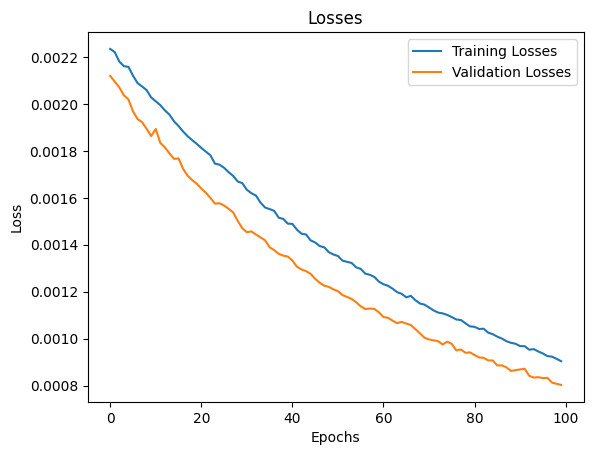

In [0]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(range(100), training_losses, label='Training Losses')
plt.plot(range(100), validation_losses, label='Validation Losses')
plt.title('Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

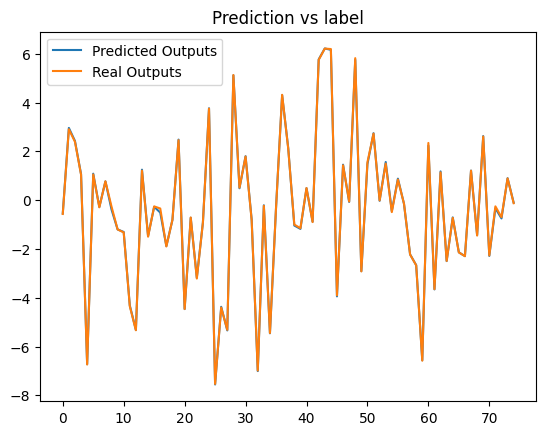

In [0]:
net.eval()
test_outputs = []
real_outputs = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to('cuda')

        outputs = net(inputs)

        test_outputs = outputs.squeeze().tolist()
        real_outputs = labels.squeeze().tolist()

plt.figure()
plt.plot(range(75), test_outputs, label='Predicted Outputs')
plt.plot(range(75), real_outputs, label='Real Outputs')
plt.title('Prediction vs label')
plt.legend()
plt.show()